### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, glob, joblib

# from sklearn.datasets import fetch_lfw_people
from tqdm import tqdm

members = ['honey', 'jane', 'philip', 'veronica', 'wai_yeong']

In [2]:
def plot_images(images, labels, n=(5, 5), random=False, title=None):

    '''Plots n images from the dataset.'''

    if random:  # Randomly sample n indices
        indices = np.random.choice(images.shape[0], size=n[0]*n[1], replace=False)
    else:  # Sample the first n indices
        indices = np.arange(n[0]*n[1])

    # Sample the images and labels
    images = images[indices]
    labels = labels[indices]

    # Plot the images
    plt.figure(figsize=(2*n[0], 2*n[1]), facecolor='white')
    for i in range(n[0]):
        for j in range(n[1]):
            index = i * n[1] + j
            plt.subplot(n[1], n[0], index+1)
            plt.imshow(images[index], cmap='gray')
            if labels[index] < len(members):
                plt.title(f'{labels[index]}: {members[labels[index]]}')
            else:
                plt.title(labels[index])
            plt.axis('off')
    if title is not None: plt.suptitle(title, y=1.1)
    plt.show()

### Define some preprocessing functions

In [3]:
def extract_n_images(images, labels, n=25):

    '''Extracts n_images images from each class in the dataset.'''
    
    out_images, out_labels = [], []

    # Get the unique classes
    unique_labels = np.unique(labels)

    # Sample n images from each class
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        np.random.shuffle(indices)
        indices = indices[:n]
        out_images.append(images[indices])
        out_labels.append(labels[indices])
    
    # Convert to numpy arrays
    out_images = np.concatenate(out_images, axis=0)  # (n_classes*n_images, h, w, c)
    out_labels = np.concatenate(out_labels, axis=0)  # (n_classes*n_images,)
    
    return out_images, out_labels

In [4]:
def resize_and_grayscale(images, size=(90, 120)):
    
    '''Resizes and converts image to grayscale.'''
    
    out_images = []
    
    # Resize and convert to grayscale
    for image in images:
        image = cv2.resize(image, size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        out_images.append(image)
    
    return np.array(out_images)

In [5]:
def print_dataset_info(images, labels):

    '''Prints information about the dataset.'''

    print(f'- Number of classes\t: {len(np.unique(labels))} ({np.unique(labels).min()} - {np.unique(labels).max()})')
    print(f'- Number of images\t: {images.shape[0]}')
    print(f'- Image size\t\t: {images.shape[1]} x {images.shape[2]}')
    print(f'- Image channels\t: {images.shape[3] if images.ndim == 4 else 1}')
    print(f'- Image value range\t: {images.min()} - {images.max()}')
    print(f'- Image dtype\t\t: {images.dtype}')

### Our dataset

In [6]:
our_images, our_labels = [], []

# Create our dataset
for i, member in enumerate(members):
    for path in glob.glob(f'../dataset/v2_output/{member}/*.png'):
        our_images.append(cv2.imread(path))
        our_labels.append(i)

our_images = np.array(our_images)
our_labels = np.array(our_labels)

print('Our dataset before preprocessing')
print_dataset_info(our_images, our_labels)

Our dataset before preprocessing
- Number of classes	: 5 (0 - 4)
- Number of images	: 250
- Image size		: 120 x 90
- Image channels	: 3
- Image value range	: 0 - 255
- Image dtype		: uint8


In [7]:
# Convert BGR to RGB, then normalise to [0, 1]
our_images = (our_images[..., ::-1] / 255.0).astype('float32')

# Resize and convert to grayscale
our_images = resize_and_grayscale(our_images, size=(90, 120))

print('Our dataset after preprocessing')
print_dataset_info(our_images, our_labels)

Our dataset after preprocessing
- Number of classes	: 5 (0 - 4)
- Number of images	: 250
- Image size		: 120 x 90
- Image channels	: 1
- Image value range	: 0.0 - 1.0
- Image dtype		: float32


### LFW dataset 

In [8]:
# # Set random seed for reproducibility
# np.random.seed(0)

# # Load the LFW dataset and extract 25 random images from each class
# lfw_people = fetch_lfw_people(min_faces_per_person=40, color=True, resize=1.0)
# lfw_images, lfw_labels = extract_n_images(lfw_people.images, lfw_people.target, n=40)

# # Offset the labels by 5 to avoid conflict with our dataset
# lfw_labels = lfw_labels + len(members)

# print('LFW dataset before preprocessing')
# print_dataset_info(lfw_images, lfw_labels)

In [9]:
# # Resize and convert to grayscale
# lfw_images = resize_and_grayscale(lfw_images, size=(75, 100))

# print('LFW dataset after preprocessing')
# print_dataset_info(lfw_images, lfw_labels)

### Combine both datasets

In [10]:
# Combine the LFW and our datasets
# images = np.concatenate([our_images, lfw_images], axis=0)
# labels = np.concatenate([our_labels, lfw_labels], axis=0)

images = np.concatenate([our_images], axis=0)
labels = np.concatenate([our_labels], axis=0)

print('Combined dataset')
print_dataset_info(images, labels)

Combined dataset
- Number of classes	: 5 (0 - 4)
- Number of images	: 250
- Image size		: 120 x 90
- Image channels	: 1
- Image value range	: 0.0 - 1.0
- Image dtype		: float32


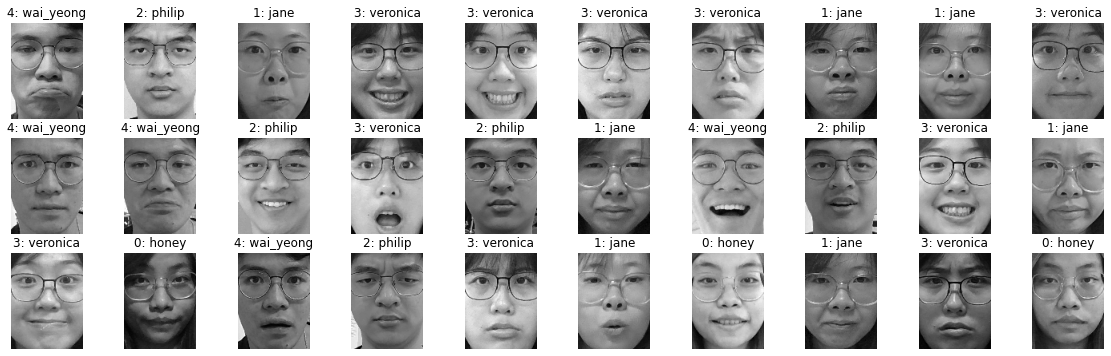

Note: Our members are labelled 0-4 and explicitly shown in the title.


In [11]:
# Set random seed for reproducibility
np.random.seed(0)
plot_images(images, labels, n=(10, 3), random=True)

print('Note: Our members are labelled 0-4 and explicitly shown in the title.')

In [12]:
# Save the images and labels to disk
np.savez_compressed('artifacts/v2_combined_dataset.npz', images=images, labels=labels)

### Perform train test split, Data Augmentation

You may use the preprocessed dataset saved earlier.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score
from cf_matrix import make_confusion_matrix
from scipy.stats import chi2

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [14]:
# Load the dataset from disk
dataset = np.load('artifacts/v2_combined_dataset.npz')
images, labels = dataset['images'], dataset['labels']
members = ['honey', 'jane', 'philip', 'veronica', 'wai_yeong', 'unknown']

# Save some variables for later use
n_classes = len(np.unique(labels))
n_images = images.shape[0]

print('n_classes:', n_classes)
print('n_images:', n_images)

n_classes: 5
n_images: 250


In [15]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.7, stratify=labels, random_state=7)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (175, 120, 90)
y_train: (175,)
X_test: (75, 120, 90)
y_test: (75,)


X_train: (350, 120, 90)
y_train: (350,)
X_test: (150, 120, 90)
y_test: (150,)


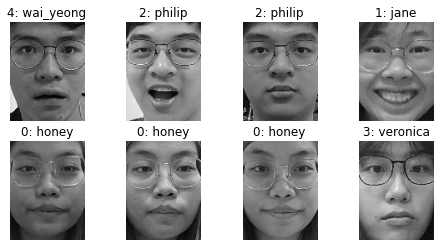

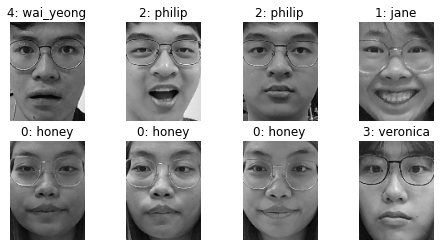

In [16]:
# Horizontally flip the images
X_train = np.concatenate([X_train, X_train[:, :, ::-1]], axis=0)
y_train = np.concatenate([y_train, y_train], axis=0)
X_test = np.concatenate([X_test, X_test[:, :, ::-1]], axis=0)
y_test = np.concatenate([y_test, y_test], axis=0)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

plot_images(X_train, y_train, n=(4, 2), random=False)
plot_images(X_train[len(X_train)//2:], y_train, n=(4, 2), random=False)

X_train: (700, 120, 90)
y_train: (700,)
X_test: (300, 120, 90)
y_test: (300,)


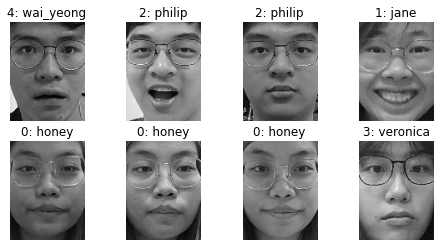

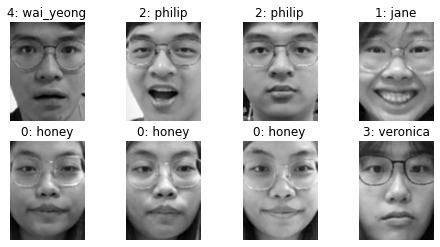

In [17]:
def gaussian_blur(images, ksize=1):
    return np.array([cv2.GaussianBlur(im, (ksize, ksize), 0) for im in images])

# Gaussian blur the images
X_train = np.concatenate([gaussian_blur(X_train, ksize=i) for i in [1,3]], axis=0)
y_train = np.concatenate([y_train]*2, axis=0)
X_test = np.concatenate([gaussian_blur(X_test, ksize=i) for i in [1,3]], axis=0)
y_test = np.concatenate([y_test]*2, axis=0)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

plot_images(X_train, y_train, n=(4, 2), random=False)
plot_images(X_train[len(X_train)//2:], y_train, n=(4, 2), random=False)

X_train: (1400, 120, 90)
y_train: (1400,)
X_test: (600, 120, 90)
y_test: (600,)


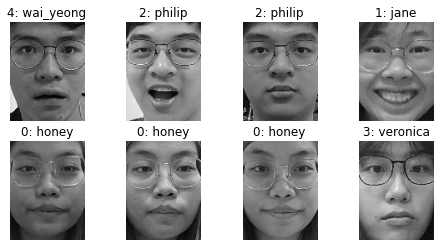

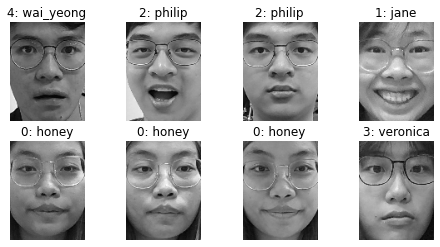

In [18]:
def random_brightness_and_contrast(images, factor=0.3):

    tf.keras.utils.set_random_seed(0)
    rand_b = tf.keras.layers.RandomBrightness(factor)
    rand_c = tf.keras.layers.RandomContrast(factor)

    images = (images * 255).astype('uint8')
    images = rand_b(images)
    images = rand_c(images)
    images = (images.numpy() / 255).astype('float32')

    return images

# Randomly adjust the brightness and contrast of the images
X_train = np.concatenate([X_train, random_brightness_and_contrast(X_train)], axis=0)
y_train = np.concatenate([y_train, y_train], axis=0)
X_test = np.concatenate([X_test, random_brightness_and_contrast(X_test)], axis=0)
y_test = np.concatenate([y_test, y_test], axis=0)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

plot_images(X_train, y_train, n=(4, 2), random=False)
plot_images(X_train[len(X_train)//2:], y_train, n=(4, 2), random=False)

In [19]:
# def normalise_sample(images):
#     return np.array([(im - np.mean(im)) / np.std(im) for im in images])

# # Normalise the images
# X_train = normalise_sample(X_train)
# X_test = normalise_sample(X_test)

In [20]:
# Convert the images to feature vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (1400, 10800)
y_train: (1400,)
X_test: (600, 10800)
y_test: (600,)


In [21]:
# Preview the image counts

df_counts = pd.DataFrame({
    'subject_id': np.arange(n_classes),
    'train': np.unique(y_train, return_counts=True)[1],
    'test': np.unique(y_test, return_counts=True)[1],
    'total': np.unique(np.concatenate([y_train, y_test], axis=0), return_counts=True)[1]
})

print('Image counts')
df_counts.set_index('subject_id').T

Image counts


subject_id,0,1,2,3,4
train,280,280,280,280,280
test,120,120,120,120,120
total,400,400,400,400,400


### Helper functions

In [22]:
def squared_mahalanobis_dist(X, mean, inv_cov):
    '''X and mean are arrays of shape (n_features, )'''
    return (X - mean) @ inv_cov @ (X - mean).T

def squared_euclidean_dist(X, mean):
    '''X and mean are arrays of shape (n_features, )'''
    return (X - mean) @ (X - mean).T

def cosine_similarity(X, mean):
    '''X and mean are arrays of shape (n_features, )'''
    return 1 - np.dot(X.T, mean) / (np.linalg.norm(X) * np.linalg.norm(mean))

In [23]:
def plot_eigenfaces(images, n=(5, 5)):

    '''Plots n eigenfaces from PCA.'''

    # Sample the images and labels
    indices = np.arange(n[0]*n[1])
    images = images[indices]

    # Plot the images
    plt.figure(figsize=(2*n[0], 2*n[1]), facecolor='white')
    for i in range(n[0]):
        for j in range(n[1]):
            index = i * n[1] + j
            plt.subplot(n[1], n[0], index+1)
            plt.imshow(images[index], cmap='gray')
            plt.title(f'Eigenface #{index+1}')
            plt.axis('off')
            
    plt.show()

### PCA

PCA loop: Finding the best `n_component`.

In [24]:
def find_best_n_component(n_comps, max_n=300, plot=True):

    res = {'train': [], 'validation': [], 'n': n_comps}

    sk_pca = PCA(n_components=max_n, svd_solver='full')
    X_train_pca_full = sk_pca.fit_transform(X_train)
    X_test_pca_full = sk_pca.transform(X_test)

    for n_components in tqdm(n_comps, desc='testing n_components'):

        X_train_pca = X_train_pca_full[:, :n_components]
        X_test_pca = X_test_pca_full[:, :n_components]

        q_j, mu_fj, sigma_fj = [], [], []

        for i in range(n_classes):
            subject_indices = np.where(y_train==i)[0]
            q_j.append(len(subject_indices))
            mu_fj.append(np.mean(X_train_pca[subject_indices], axis=0))
            sigma_fj.append(np.cov(X_train_pca[subject_indices].T))

        q_j, mu_fj, sigma_fj = np.array(q_j), np.array(mu_fj), np.array(sigma_fj)
        sigma_w_f = np.sum([q_j[i] * sigma_fj[i] for i in range(n_classes)], axis=0) / np.sum(q_j)
        inv_sigma_w_f = np.linalg.inv(sigma_w_f)
        threshold = chi2.ppf(0.999, n_components)

        y_train_preds, y_test_preds = [], []

        for i in range(len(X_train_pca)):
            dist = np.array([squared_mahalanobis_dist(X_train_pca[i], mu_fj[j], inv_sigma_w_f) for j in range(n_classes)])
            min_dist_index = np.argmin(dist)
            y_train_preds.append(min_dist_index if dist[min_dist_index] < threshold else len(members))

        for i in range(len(X_test_pca)):
            dist = np.array([squared_mahalanobis_dist(X_test_pca[i], mu_fj[j], inv_sigma_w_f) for j in range(n_classes)])
            min_dist_index = np.argmin(dist)
            y_test_preds.append(min_dist_index if dist[min_dist_index] < threshold else len(members))

        res['train'].append(accuracy_score(y_train, y_train_preds))
        res['validation'].append(accuracy_score(y_test, y_test_preds))

    if plot:
        plot_res(res)

    return res


def plot_res(res):

    plt.figure(figsize=(8, 4))
    plt.plot(res['n'], res['train'], label='train')
    plt.plot(res['n'], res['validation'], label='validation')
    plt.xlabel('number of principal components')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

testing n_components: 100%|██████████| 87/87 [00:39<00:00,  2.18it/s]


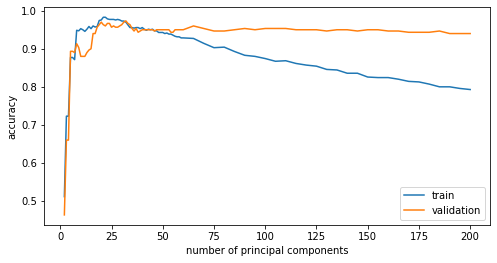

In [25]:
n_comp_range = list(range(2, 60)) + list(range(60, 201, 5))
find_best_n_component(n_comp_range, max_n=200, plot=True);

testing n_components: 100%|██████████| 74/74 [00:06<00:00, 11.23it/s]


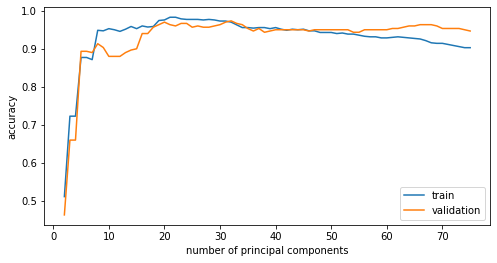

In [26]:
n_comp_range = list(range(2, 76))
find_best_n_component(n_comp_range, max_n=200, plot=True);

Save the PCA model

In [27]:
n_components = 30

# PCA from sklearn
sk_pca = PCA(n_components=n_components, svd_solver='full')
X_train_pca = sk_pca.fit_transform(X_train)
X_test_pca = sk_pca.transform(X_test)

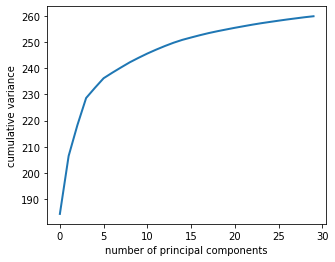

In [28]:
# Plot the cumulative explained variance
plt.figure(figsize=(5, 4), facecolor='white')
plt.plot(np.cumsum(sk_pca.explained_variance_), linewidth=2)
plt.xlabel('number of principal components')
plt.ylabel('cumulative variance')
plt.show()

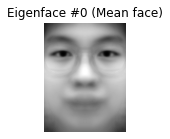

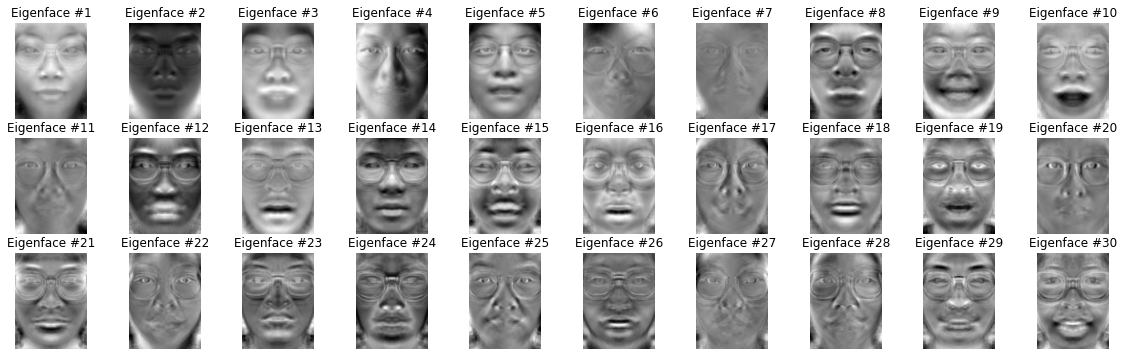

In [29]:
# Plot the mean face
plt.figure(figsize=(2, 2), facecolor='white')
plt.imshow(sk_pca.mean_.reshape(120, 90), cmap='gray')
plt.title(f'Eigenface #0 (Mean face)')
plt.axis('off')

# Plot the eigenfaces
plot_eigenfaces(sk_pca.components_.reshape((n_components, 120, 90)), n=(10, 3))

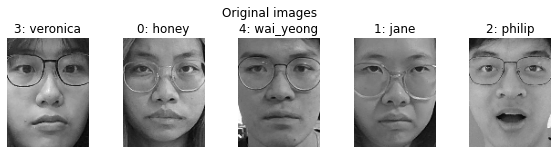

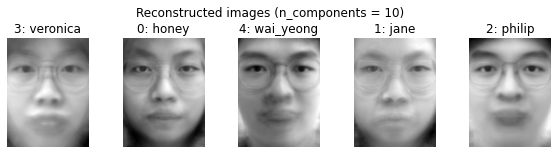

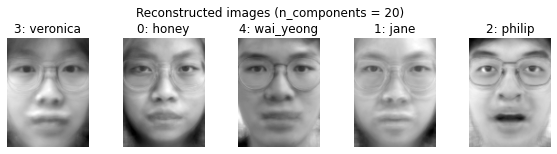

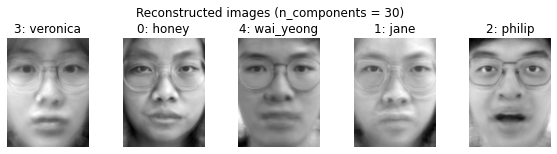

In [30]:
s_low, s_high = 7, 12
plot_images(X_train.reshape(-1, 120, 90)[s_low:s_high], y_train[s_low:s_high], n=(5, 1),
            random=False, title='Original images')

for sub_n in range(10, 31, 10):
    X_reconstructed = X_train_pca[:, :sub_n] @ sk_pca.components_[:sub_n, :] + sk_pca.mean_
    plot_images(X_reconstructed.reshape(-1, 120, 90)[s_low:s_high], y_train[s_low:s_high], n=(5, 1),
                random=False, title=f'Reconstructed images (n_components = {sub_n})')

In [31]:
q_j, mu_fj, sigma_fj = [], [], []

for i in range(n_classes):
    subject_indices = np.where(y_train==i)[0]
    q_j.append(len(subject_indices))
    mu_fj.append(np.mean(X_train_pca[subject_indices], axis=0))
    sigma_fj.append(np.cov(X_train_pca[subject_indices].T))

q_j, mu_fj, sigma_fj = np.array(q_j), np.array(mu_fj), np.array(sigma_fj)
sigma_w_f = np.sum([q_j[i] * sigma_fj[i] for i in range(n_classes)], axis=0) / np.sum(q_j)
inv_sigma_w_f = np.linalg.inv(sigma_w_f)

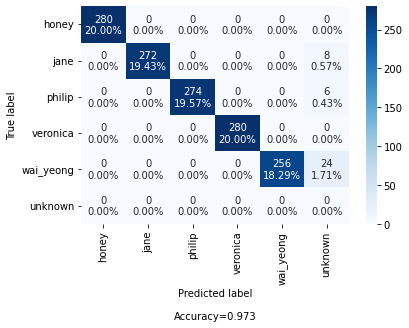

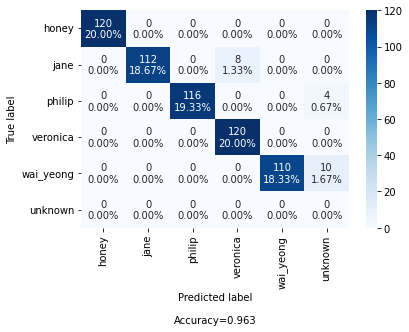

In [32]:
# inv_sigma_w_f = np.diag(1 / sk_pca.explained_variance_[:n_components])

y_train_preds, y_test_preds = [], []
y_train_dists, y_test_dists = [], []

threshold = chi2.ppf(0.999, n_components)

for i in range(len(X_train_pca)):

    dist = np.array([squared_mahalanobis_dist(X_train_pca[i], mu_fj[j], inv_sigma_w_f) for j in range(n_classes)])
    # dist = np.array([squared_euclidean_dist(X_train_pca[i], mu_fj[j]) for j in range(n_classes)])
    # dist = np.array([cosine_similarity(X_train_pca[i], mu_fj[j]) for j in range(n_classes)])
    min_dist_index = np.argmin(dist)
    y_train_preds.append(min_dist_index if dist[min_dist_index] < threshold else len(members))
    y_train_dists.append(dist)

for i in range(len(X_test_pca)):

    dist = np.array([squared_mahalanobis_dist(X_test_pca[i], mu_fj[j], inv_sigma_w_f) for j in range(n_classes)])
    # dist = np.array([squared_euclidean_dist(X_test_pca[i], mu_fj[j]) for j in range(n_classes)])
    # dist = np.array([cosine_similarity(X_train_pca[i], mu_fj[j]) for j in range(n_classes)])
    min_dist_index = np.argmin(dist)
    y_test_preds.append(min_dist_index if dist[min_dist_index] < threshold else len(members))
    y_test_dists.append(dist)

make_confusion_matrix(confusion_matrix(y_train, y_train_preds), categories=members);
make_confusion_matrix(confusion_matrix(y_test, y_test_preds), categories=members);

In [33]:
joblib.dump(sk_pca, 'artifacts/sk_pca_nclass_5.joblib')
np.savez_compressed('artifacts/wfj_pca_nclass_5.npz', mu_fj=mu_fj, inv_sigma_w_f=inv_sigma_w_f)

### LDA

In [34]:
sk_lda = LinearDiscriminantAnalysis()
X_train_lda = sk_lda.fit_transform(X_train_pca, y_train)
X_test_lda = sk_lda.transform(X_test_pca)

In [35]:
q_j, mu_fj, sigma_fj = [], [], []

for i in range(n_classes):
    subject_indices = np.where(y_train==i)[0]
    q_j.append(len(subject_indices))
    mu_fj.append(np.mean(X_train_lda[subject_indices], axis=0))
    sigma_fj.append(np.cov(X_train_lda[subject_indices].T))

q_j, mu_fj, sigma_fj = np.array(q_j), np.array(mu_fj), np.array(sigma_fj)
sigma_w_f = np.sum([q_j[i] * sigma_fj[i] for i in range(n_classes)], axis=0) / np.sum(q_j)
inv_sigma_w_f = np.linalg.inv(sigma_w_f)

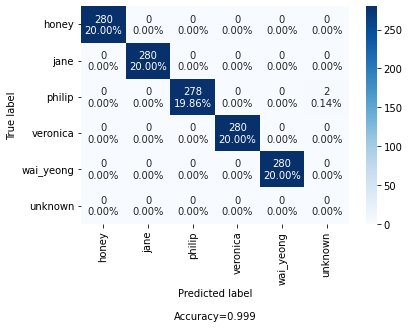

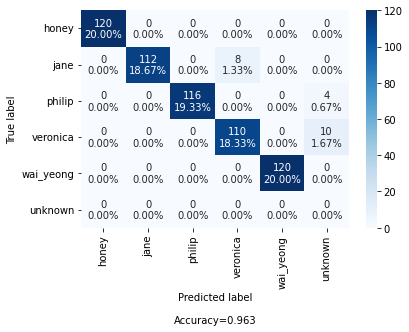

In [36]:
y_train_preds, y_test_preds = [], []
y_train_dists, y_test_dists = [], []
threshold = chi2.ppf(0.999, X_train_lda.shape[1])

for i in range(len(X_train_lda)):

    dist = np.array([squared_mahalanobis_dist(X_train_lda[i], mu_fj[j], inv_sigma_w_f) for j in range(n_classes)])
    # dist = np.array([squared_euclidean_dist(X_train_lda[i], mu_fj[j]) for j in range(n_classes)])
    # dist = np.array([cosine_similarity(X_train_lda[i], mu_fj[j]) for j in range(n_classes)])
    min_dist_index = np.argmin(dist)
    y_train_preds.append(min_dist_index if dist[min_dist_index] < threshold else len(members))
    y_train_dists.append(dist)

for i in range(len(X_test_lda)):

    dist = np.array([squared_mahalanobis_dist(X_test_lda[i], mu_fj[j], inv_sigma_w_f) for j in range(n_classes)])
    # dist = np.array([squared_euclidean_dist(X_test_lda[i], mu_fj[j]) for j in range(n_classes)])
    # dist = np.array([cosine_similarity(X_train_lda[i], mu_fj[j]) for j in range(n_classes)])
    min_dist_index = np.argmin(dist)
    y_test_preds.append(min_dist_index if dist[min_dist_index] < threshold else len(members))
    y_test_dists.append(dist)

make_confusion_matrix(confusion_matrix(y_train, y_train_preds), categories=members);
make_confusion_matrix(confusion_matrix(y_test, y_test_preds), categories=members);

In [37]:
joblib.dump(sk_lda, 'artifacts/sk_lda_nclass_5.joblib')
np.savez_compressed('artifacts/wfj_lda_nclass_5.npz', mu_fj=mu_fj, inv_sigma_w_f=inv_sigma_w_f)

### Logistic Regression

c:\Users\Philip\anaconda3\envs\ee4208\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['artifacts/logreg_pca_nclass_5.joblib']

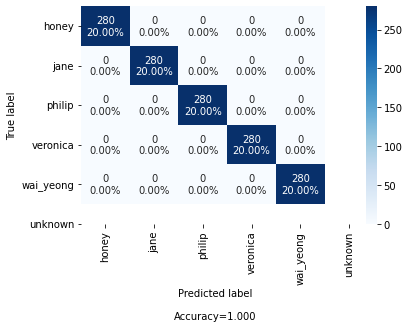

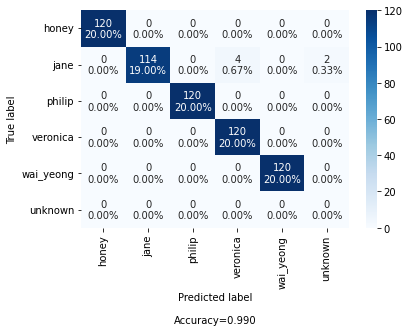

In [38]:
logreg_pca = LogisticRegression()
logreg_pca.fit(X_train_pca, y_train)

y_train_preds = logreg_pca.predict_proba(X_train_pca)
y_train_unknown = y_train_preds.max(axis=1) <= 0.5
y_train_preds = y_train_preds.argmax(axis=1)
y_train_preds[y_train_unknown] = len(members)

y_test_preds = logreg_pca.predict_proba(X_test_pca)
y_test_unknown = y_test_preds.max(axis=1) <= 0.5
y_test_preds = y_test_preds.argmax(axis=1)
y_test_preds[y_test_unknown] = len(members)

make_confusion_matrix(confusion_matrix(y_train, y_train_preds), categories=members);
make_confusion_matrix(confusion_matrix(y_test, y_test_preds), categories=members);

joblib.dump(logreg_pca, 'artifacts/logreg_pca_nclass_5.joblib')

['artifacts/logreg_lda_nclass_5.joblib']

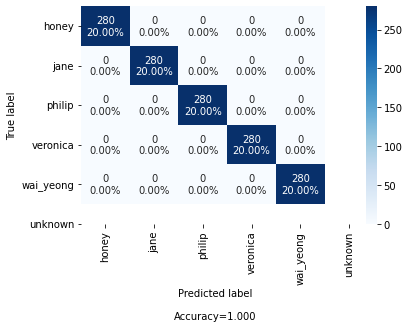

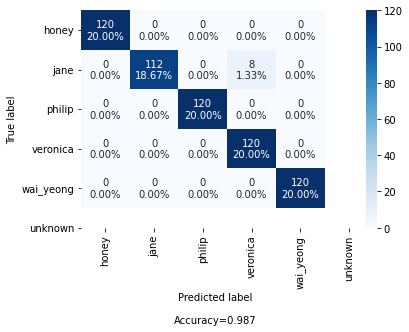

In [39]:
logreg_lda = LogisticRegression()
logreg_lda.fit(X_train_lda, y_train)

y_train_preds = logreg_lda.predict_proba(X_train_lda)
y_train_unknown = y_train_preds.max(axis=1) <= 0.5
y_train_preds = y_train_preds.argmax(axis=1)
y_train_preds[y_train_unknown] = len(members)

y_test_preds = logreg_lda.predict_proba(X_test_lda)
y_test_unknown = y_test_preds.max(axis=1) <= 0.5
y_test_preds = y_test_preds.argmax(axis=1)
y_test_preds[y_test_unknown] = len(members)

make_confusion_matrix(confusion_matrix(y_train, y_train_preds), categories=members);
make_confusion_matrix(confusion_matrix(y_test, y_test_preds), categories=members);

joblib.dump(logreg_lda, 'artifacts/logreg_lda_nclass_5.joblib')

### Keras Classifier

In [40]:
y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

In [41]:
model_pca = Sequential([
    Dense(256, activation='relu', input_dim=X_train_pca.shape[1]),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

model_pca.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model_pca.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 3

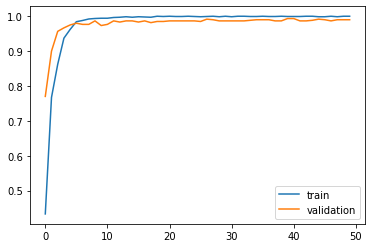

In [42]:
tf.keras.utils.set_random_seed(0)
history = model_pca.fit(X_train_pca, y_train_cat, epochs=50, validation_data=(X_test_pca, y_test_cat), batch_size=120, verbose=0)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

19/19 [==============================] - 0s 1ms/step


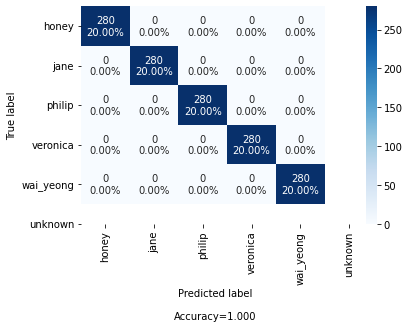

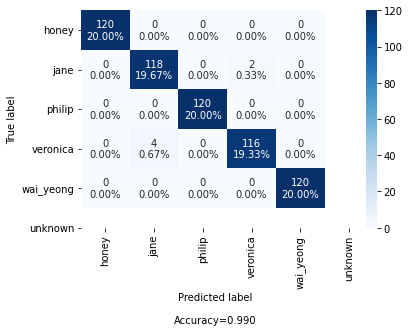

In [43]:
y_train_preds = model_pca.predict(X_train_pca)
y_train_unknown = y_train_preds.max(axis=1) <= 0.5
y_train_preds = y_train_preds.argmax(axis=1)
y_train_preds[y_train_unknown] = len(members)

y_test_preds = model_pca.predict(X_test_pca)
y_test_unknown = y_test_preds.max(axis=1) <= 0.5
y_test_preds = y_test_preds.argmax(axis=1)
y_test_preds[y_test_unknown] = len(members)

make_confusion_matrix(confusion_matrix(y_train, y_train_preds), categories=members);
make_confusion_matrix(confusion_matrix(y_test, y_test_preds), categories=members);

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_pca)
tflite_model = converter.convert()

# Save the model.
with open('artifacts/keras_pca_nclass_5.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Philip\AppData\Local\Temp\tmppuw4h254\assets


In [45]:
model_lda = Sequential([
    Dense(256, activation='relu', input_dim=X_train_lda.shape[1]),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

model_lda.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model_lda.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               1280      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                

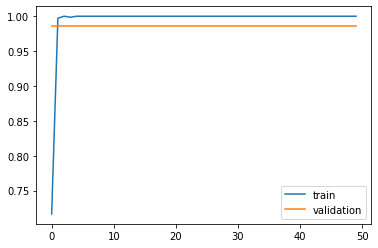

In [46]:
history = model_lda.fit(X_train_lda, y_train_cat, epochs=50, validation_data=(X_test_lda, y_test_cat), batch_size=120, verbose=0)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

19/19 [==============================] - 0s 2ms/step


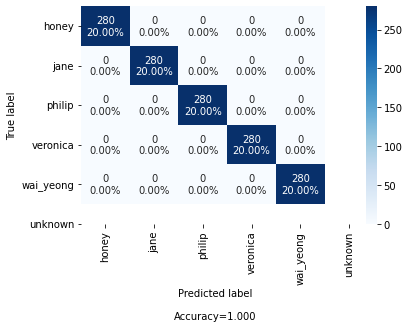

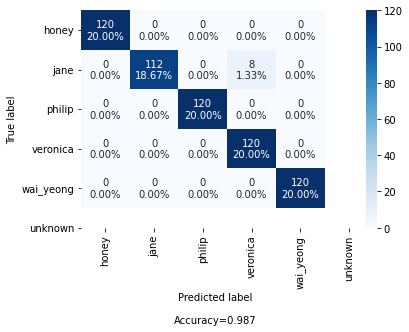

In [47]:
y_train_preds = model_lda.predict(X_train_lda)
y_train_unknown = y_train_preds.max(axis=1) <= 0.5
y_train_preds = y_train_preds.argmax(axis=1)
y_train_preds[y_train_unknown] = len(members)

y_test_preds = model_lda.predict(X_test_lda)
y_test_unknown = y_test_preds.max(axis=1) <= 0.5
y_test_preds = y_test_preds.argmax(axis=1)
y_test_preds[y_test_unknown] = len(members)

make_confusion_matrix(confusion_matrix(y_train, y_train_preds), categories=members);
make_confusion_matrix(confusion_matrix(y_test, y_test_preds), categories=members);

In [48]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_lda)
tflite_model = converter.convert()

# Save the model.
with open('artifacts/keras_lda_nclass_5.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Philip\AppData\Local\Temp\tmpe_pgw28w\assets


INFO:tensorflow:Assets written to: C:\Users\Philip\AppData\Local\Temp\tmpe_pgw28w\assets


### Copy to final prototype folder

In [49]:
import shutil

shutil.copytree('artifacts', '../prototype/artifacts/classification', dirs_exist_ok=True)

'../prototype/artifacts/classification'